## 핸즈온 머신러닝 2장 - 주택 가격 예측 모델 생성해 보기
구역(6백-3천명이 사는 구역)에 대한 정보를 가지고 그 구역의 중간(median) 주택 가격 예측 -> **지도학습, 회귀(다변량) 문제!**

1. 데이터 다운로드

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [146]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [147]:
import pandas as pd
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [160]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [20]:
print(housing.ocean_proximity.unique())
print(housing.ocean_proximity.value_counts())

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


In [35]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


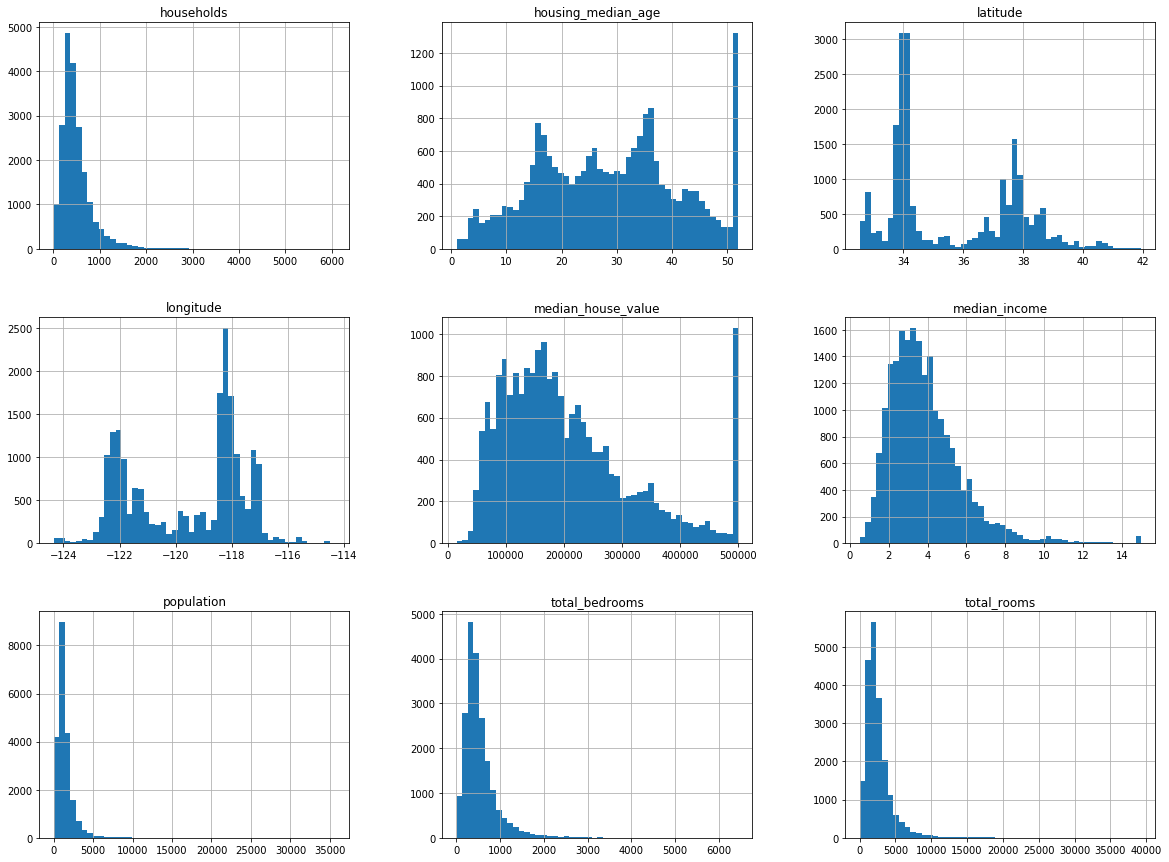

In [37]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [48]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # 행 길이만큼 난수 생성(0에서 len(data)까지)
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size] # 0부터 test_set_size 까지 행이 test set
    train_indices = shuffled_indices[test_set_size:] # 나머지가 train set
    return data.iloc[train_indices], data.iloc[test_indices]

In [49]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), len(test_set))

16512 4128


In [53]:
#random으로 추출했을 때 항상 같은 train set, test set만 나오게 하는 코드
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
#0xffffffff -> (2**4)**8 -1. 즉 2**32 -1. 행 인덱스(정수)의 고유값(crc32) 이용하여 구분함

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [62]:
housing_with_id = housing.reset_index() #행(인덱스)를 식별자로 사용. 컬럼으로 바꿈
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(train_set.index[:5], test_set.index[:5])

Int64Index([0, 1, 3, 4, 6], dtype='int64') Int64Index([2, 5, 12, 16, 23], dtype='int64')


In [74]:
#housing.reset_index()['index'].apply(lambda x: test_set_check(x, 0.2))
0xfff

4095

In [97]:
crc32(np.int64(22)) & 0xffffffff

4294967295

In [90]:
#변하지 않을 값(가정)인 위도, 경도를 이용하여 id 칼럼 생성해 보기
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [91]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


## 층화 추출하기(소득 카테고리(income_cat) 비율 같게)

In [161]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) #median_income은 최소 0.4999, 최대 15.0001이므로 1.5로 나누면 0~10값 가짐.
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True) #Series.where -> 조건이 True이면 그대로, False이면(5보다 크거나 같으면) 5.0으로 바꿈
#2번째 줄은 아마 income이 오른쪽 꼬리가 길어서, 소득이 큰 부분은 같은 카테고리로 묶는 듯

In [162]:
housing.income_cat.value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

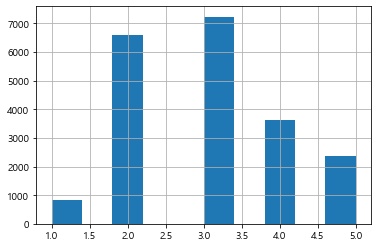

In [163]:
housing["income_cat"].hist()
plt.show()

In [164]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]): #income_cat 칼럼 비율을 같게 하여 housing 데이터를 층화 split
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [165]:
#전체 데이터, train, test set에서 income_cat 비율
print(housing["income_cat"].value_counts() / len(housing))
print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [166]:
# income_cat 컬럼 삭제하여 원래 데이터로 돌리기
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [167]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


## 데이터 시각화

In [168]:
#train, test가 잘 나눠졌는지 확인
print(len(strat_train_set), len(strat_test_set), len(housing))

16512 4128 20640


In [169]:
housing = strat_train_set.copy() # train set 손상시키지 않기 위해 복사본 만들어 사용

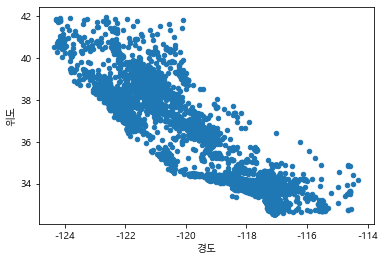

In [179]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

ax = housing.plot(kind = "scatter", x = "longitude", y = "latitude")
ax.set_xlabel("경도")
ax.set_ylabel("위도")
plt.rc('font', family = 'malgun gothic')

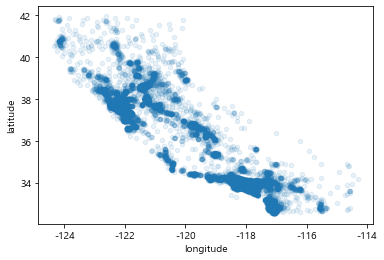

In [180]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha=0.1) #밀집된 지역을 부각시키는 산점도

In [181]:
housing.ocean_proximity.value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

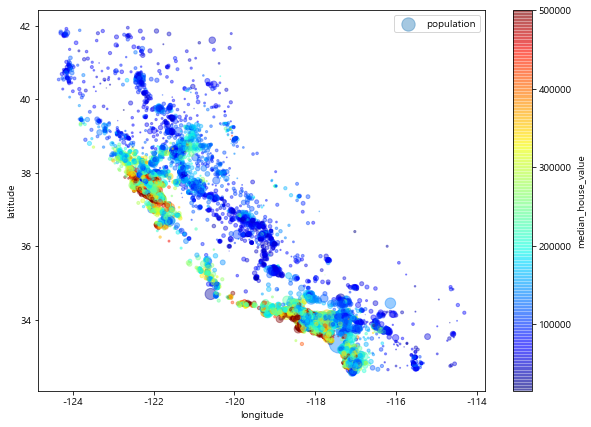

In [182]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"] / 100, label = "population", figsize = (10, 7), # s는 인구. 원의 반지름이 클수록 인구가 큰 곳
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True, sharex = False) # c는 집값(median_house_value)에 따른 색 나타냄. jet는 컬러맵 종류
plt.legend()

In [183]:
corr_matrix = housing.corr()

In [184]:
corr_matrix["median_house_value"].sort_values(ascending = False) #집값과의 상관관계 보기

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C7B048EF0>,
      dtype=object)

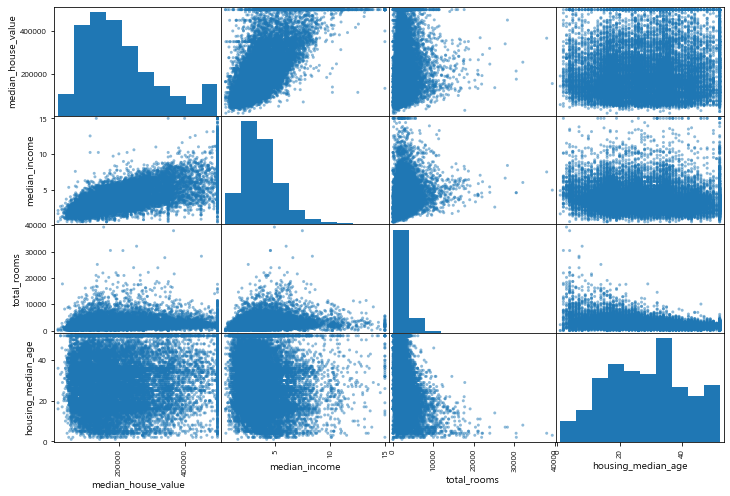

In [186]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"] #상관계수가 0.1 이상인 컬럼들의 산점도 행렬 보기
scatter_matrix(housing[attributes], figsize=(12, 8))

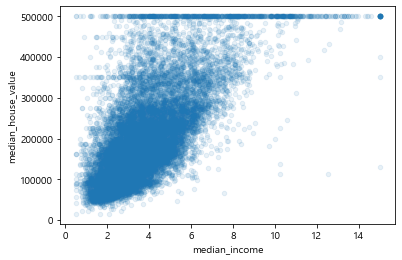

In [187]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha=0.1)

In [192]:
# 특성들 만들어 보기. 이것들과 집값의 상관관계 보기
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"] #가구당 방 개수
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"] #방당 침대 개수
housing["population_per_household"] = housing["population"] / housing["households"] #가구당 인원

In [193]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## 머신러닝 알고리즘을 위한 데이터 준비

In [351]:
#예측 변수와 레이블 분리
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [214]:
#null 이 있는 total_bedrooms 칼럼 준비
housing[housing["total_bedrooms"].isnull()].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [215]:
#누락된 값 다루는 패키지
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [216]:
housing_num = housing.drop("ocean_proximity", axis=1) #median은 numeric 데이터에서만 적용 -> 텍스트 특성 제거

In [217]:
imputer.fit(housing_num) #각 특성의 중간값을 계산해서 객체에 저장

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [219]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [221]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [222]:
X = imputer.transform(housing_num) #누락된 값을 학습한 중간값으로 바꿈. 근데 이건 ndarray이므로 DataFrame으로 바꾸어 줌(아래)

In [223]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = list(housing.index.values))

In [224]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## 텍스트와 범주형 특성 다루기

In [352]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [353]:
housing_cat_encoded, housing_categories = housing_cat.factorize() #숫자형으로 바꾸어 줌
print(housing_cat_encoded[:10])
print(housing_categories) #근데 숫자 값이 비슷하면 떨어져 있는 값보다 비슷하다고 생각함 -> one hot encoding 필요

[0 0 1 2 0 2 0 2 0 0]
Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')


In [409]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories="auto", sparse=False)
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
#fit_transform 메소드는 2차원 배열 넣어줘야 함 -> 1차원이므로 바꿔줌
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [248]:
# 변수들 추가하는 클래스 만들기
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): #디폴트를 True로 주어, 방당 침대 수 칼럼이 추가되게 함
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        popultaion_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, popultaion_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, popultaion_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## 이와 같이 연속된 변환(onehot, 정규화, 표준화 등)을 pipeline으로 한번에 처리하기

In [250]:
# housing_num -> housing.drop("ocean_proximity", axis=1)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [252]:
housing_num_tr[0]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
        0.15531753])

In [253]:
# sklearn은 DataFrame을 직접 넣을 수는 없음. 변환기를 만들어 사용
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [1]:
#list(housing_num) #칼럼명들을 가지는 list
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

class ToArrayEncoder(OneHotEncoder):
    def __init__(self, categories):
        self.categories = "auto"
    def fit(self, X, Y=None):
        return self
    def transform(self, X, Y=None):
        encoder = OneHotEncoder(self.categories)
        reshaped = encoder.fit_transform(X.reshape(-1, 1))
        return reshaped.toarray()

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)), #ocean_proximity 열만 선택
    ('cat_encoder', OneHotEncoder(categories='auto', sparse=False))
])

NameError: name 'housing_num' is not defined

## 두 파이프라인을 하나로 합치기

In [405]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [406]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [358]:
housing_prepared.shape # 8개의 숫자형 변수 + 3개의 추가 변수(per) + 범주형 변수(ocean_proximity)를 one hot 한 5개의 변수

(16512, 16)

## 모델 선택과 훈련

In [359]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [360]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("예측:", lin_reg.predict(some_data_prepared))
print("레이블:", list(some_labels))

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [367]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #root mean squared error(RMSE) 측정

68628.19819848923

In [407]:
# 집값 스케일(대부분 12만 ~ 26.5만)에 비해 RMSE가 매우 큼 -> 더 복잡한 모델 시도
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [408]:
housing_predictions = tree_leg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse #과대적합 된 것으로 보임

0.0

In [339]:
housing_test = strat_test_set.drop("median_house_value", axis=1)
housing_test_labels = strat_test_set["median_house_value"].copy()

In [341]:
housing_test_prepared = full_pipeline.fit_transform(housing_test).toarray()
housing_test_prepared

array([[ 0.57471497, -0.69620912,  0.03285951, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83839441, -0.86074221,  0.82471029, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24635944, -0.65390061, -0.12551065, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.52496413, -0.66800344,  0.19122966, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.10704893, -0.75732141, -0.12551065, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31601062,  0.55894333, -0.75899128, ...,  0.        ,
         0.        ,  0.        ]])

In [342]:
housing_test_predictions = tree_leg.predict(housing_test_prepared)
tree_mse_test = mean_squared_error(housing_test_labels, housing_test_predictions)
tree_rmse_test = np.sqrt(tree_mse_test)
tree_rmse_test #test set에 적용해 보니 RMSE가 11만으로 굉장히 큼!!

110551.72101879636

## 따라서 cross validation 필요.

In [376]:
from sklearn.model_selection import cross_val_score
#train set을 10개의 fold로 무작위로 분할. 결정 트리 모델을 10번 훈련하고 평가
#10개의 평가 점수가 담긴 배열(ndarray)이 결과가 됨
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [377]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rmse_scores) #선형회귀 모델보다 cost가 큼.

Scores: [69541.11025877 67253.81363245 71812.04283981 69883.64427511
 70995.08693502 75991.08056093 72262.17513485 72102.05506221
 78627.84003156 70225.77590872]
Mean: 71869.46246394259
Standard Deviation: 3114.6456093627025


In [372]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores) #디시전 트리보다 작음. 디시전 트리는 과대적함 된 것

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798349


In [380]:
##마지막으로 RandomForestRegressor 사용
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions)
print("RMSE:", np.sqrt(forest_rmse)) #훈련 세트에 대한 RMSE

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring = "neg_mean_squared_error", cv = 10)
forest_rmse = np.sqrt(-forest_scores)
display_scores(forest_rmse) #검증 세트에 대한 RMSE들 -> train set의 RMSE보다 높으므로 여전히 과대적합

RMSE: 22121.489457508636
Scores: [52546.56991385 51076.44865316 52030.58730511 54385.16537999
 51967.79565735 56122.0823771  52343.08910756 49162.15391393
 55091.8635946  52650.3404128 ]
Mean: 52737.60963154533
Standard Deviation: 1911.732185115887


## 모델들 세부 튜닝

In [381]:
#최적의 하이퍼파라미터 조합 탐색하기
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor(n_estimators=10)
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
    

In [382]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [383]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [388]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params) # (6, 30) 조합에서 RMSE인 49812가 가장 낮음 -> 기본 파라미터 설정(52737)일 때보다 조금 더 좋음
print(np.sqrt(-cvres["mean_test_score"]).min())

64059.70811421006 {'max_features': 2, 'n_estimators': 3}
55717.34281070854 {'max_features': 2, 'n_estimators': 10}
52886.15482946245 {'max_features': 2, 'n_estimators': 30}
60419.67087671865 {'max_features': 4, 'n_estimators': 3}
52906.833922447935 {'max_features': 4, 'n_estimators': 10}
50545.45710514346 {'max_features': 4, 'n_estimators': 30}
58480.92526325962 {'max_features': 6, 'n_estimators': 3}
52255.84259682926 {'max_features': 6, 'n_estimators': 10}
49812.76637418533 {'max_features': 6, 'n_estimators': 30}
58370.43233721377 {'max_features': 8, 'n_estimators': 3}
52083.12553779204 {'max_features': 8, 'n_estimators': 10}
49902.17856585846 {'max_features': 8, 'n_estimators': 30}
62892.830174829236 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54440.02874335172 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60761.26776568052 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52604.68306847227 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [389]:
#각 특성의 상대적인 중요도 보기
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.48163653e-02, 7.29942183e-02, 4.02246250e-02, 1.73661700e-02,
       1.70656567e-02, 1.71658781e-02, 1.66518821e-02, 3.02336642e-01,
       6.45221301e-02, 1.06947336e-01, 8.55565419e-02, 1.73437301e-02,
       1.45239853e-01, 4.81346407e-05, 4.50020509e-03, 7.22063182e-03])

In [424]:
#중요도와 특성 이름 같이 표시
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(pd.Series(housing_cat.unique()).sort_values())
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.30233664230149476, 'median_income'),
 (0.14523985275932816, 'INLAND'),
 (0.10694733581978785, 'pop_per_hhold'),
 (0.08555654191176638, 'bedrooms_per_room'),
 (0.0848163652609444, 'longitude'),
 (0.07299421826218569, 'latitude'),
 (0.06452213009758348, 'rooms_per_hhold'),
 (0.04022462503299363, 'housing_median_age'),
 (0.017366169964888194, 'total_rooms'),
 (0.01734373013878283, '<1H OCEAN'),
 (0.017165878058233164, 'population'),
 (0.017065656700793075, 'total_bedrooms'),
 (0.01665188213630622, 'households'),
 (0.007220631822280966, 'NEAR OCEAN'),
 (0.004500205091907736, 'NEAR BAY'),
 (4.81346407234461e-05, 'ISLAND')]

## test set으로 시스템 평가하기

In [426]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse # 47758

47758.00181412286

In [431]:
print(y_test.head(5))
print(final_predictions[:5])

5241     500001.0
10970    240300.0
20351    218200.0
6568     182100.0
13285    121300.0
Name: median_house_value, dtype: float64
[477887.43333333 269346.73333333 245723.36666667 213600.
 131533.33333333]


In [465]:
test_and_pred = pd.concat([pd.Series(y_test.values), pd.Series(final_predictions)], axis=1)
test_and_pred.columns = ["test", "pred"]
print(len(test_and_pred))
test_and_pred.head()

4128


,test,pred
0,500001.0,477887.433333
1,240300.0,269346.733333
2,218200.0,245723.366667
3,182100.0,213600.000000
4,121300.0,131533.333333


In [464]:
test_and_pred = test_and_pred[test_and_pred.test != test_and_pred.test.max()]
print(len(test_and_pred))
test_and_pred.head()

3944


,test,pred
1,240300.0,269346.733333
2,218200.0,245723.366667
3,182100.0,213600.000000
4,121300.0,131533.333333
5,120600.0,133560.000000


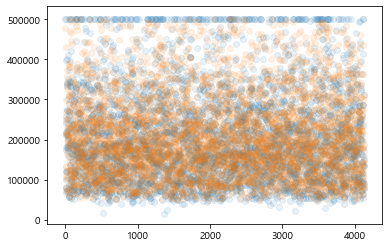

In [468]:
plt.scatter(test_and_pred.index, test_and_pred.test, alpha=0.1)
plt.scatter(test_and_pred.index, test_and_pred.pred, alpha=0.1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
